# Lesson 7 : Multi-label classification

- Video >> https://youtu.be/0frKXR-2PBY
- wiki >> http://forums.fast.ai/t/part-2-lesson-9-in-class/14028/1
- Lesson notes >> https://medium.com/@hiromi_suenaga/deep-learning-2-part-2-lesson-9-5f0cf9e4bb5b


<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/07_multi label classification/cours_7.png" width="80%">

From the previous lesson, we have learnt how to detect and classify an object from the same model. 
Now, we want to extend to multiple label classification. But, we know already how to do that, right?

In [ ]:
! pip install --upgrade git+https://github.com/keras-team/keras.git \
                        git+https://github.com/valeoai/dl_utils.git \
                        imageio

  Cloning https://github.com/keras-team/keras.git to /tmp/pip-req-build-8fdpqeow
  Cloning https://github.com/valeoai/dl_utils.git to /tmp/pip-req-build-y2bmdnuz
Requirement already up-to-date: imageio in /usr/local/lib/python3.6/dist-packages (2.5.0)
  Stored in directory: /tmp/pip-ephem-wheel-cache-upk1xj1w/wheels/da/a4/7e/6b7bd9af18cc2e23b8dd5ed6de07a7e13bd80a17214eb88932
  Stored in directory: /tmp/pip-ephem-wheel-cache-upk1xj1w/wheels/71/ad/e4/ef0ed3b20fc1828e7eb4b7fddc4342ae6a7672d62fa2b89c6a
Successfully built Keras dl-utils
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
  Found existing installation: dl-utils 0.1
    Uninstalling dl-utils-0.1:
      Successfully uninstalled dl-utils-0.1


In [ ]:
import keras
from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dropout, Flatten,Dense
from keras.optimizers import Adam

import numpy as np
import os
from matplotlib import image,patches,patheffects
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import json
import collections
import pandas as pd

from dlutils import unpreprocess

Using TensorFlow backend.


## Setup (as previous lesson)

In [ ]:
import os
if not os.path.isdir('./VOCdevkit/'):
    ! wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
    ! tar -xf VOCtrainval_06-Nov-2007.tar
    #! wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
    #! unzip -q PASCAL_VOC.zip -d VOCdevkit/VOC2007
    ! mv /content/gdrive/My\ Drive/Colab\ Notebooks/Practical_DL_ITI_2019_CV/voc2coco/pascal_train2007.json VOCdevkit/VOC2007/pascal_train2007.json 
    #! rm -Rf VOCdevkit/VOC2007/PASCAL_VOC

In [ ]:
PATH = Path('VOCdevkit/VOC2007')
BD = json.load((PATH / 'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

data_category = dict((o[ID], o['name']) for o in BD[CATEGORIES])
data_filename = dict((o[ID], o[FILE_NAME]) for o in BD[IMAGES])
data_ids = [o[ID] for o in BD[IMAGES]]

IMG_PATH = PATH/'JPEGImages'

Notice this time, we dont only get the largest box, but all of them


In [ ]:
def get_annotation():
    annotations = collections.defaultdict(lambda:[])
    for o in BD[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            annotations[o[IMG_ID]].append((bb,o[CAT_ID]))
    return annotations

train_annotation = get_annotation()

In [ ]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [ ]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], data_category[c], sz=16)

def draw_idx(i):
    im_a = train_annotation[i]
    im = open_image(IMG_PATH/data_filename[i])
    draw_im(im, im_a)

# Multi class classification

### 1: The Data

In [ ]:
mc = []
for o in data_ids:
    c = np.zeros(len(data_category),dtype=int)
    for p in train_annotation[o]:
        c[p[1]-1]=1
    mc.append(c)
mc = np.asarray(mc)# Not One Hot Encoding, but could include multi-1's
class_name=[o['name'] for o in BD[CATEGORIES]]# Reverse mapping from ID to class name
filename = [data_filename[o] for o in data_ids]

In [ ]:
df=pd.DataFrame(mc,columns=class_name)
df['filename'] = pd.Series(filename, index=df.index)

def Split_Train_Valid(df,Split_train_val=0.7):
    # step 1: shuffle the data
    df = df.reindex(np.random.permutation(df.index))
    df=df.set_index(np.arange(len(df)))
    
    # step 2: split in training and testing
    df_train = df[:int(len(df)*Split_train_val)]
    df_valid = df[int(len(df)*Split_train_val):]
    df_train=df_train.set_index(np.arange(len(df_train)))
    df_valid=df_valid.set_index(np.arange(len(df_valid)))
    
    return df_train,df_valid

df_train, df_valid = Split_Train_Valid(df,0.7)

Notice how the we can have more that 1 for each image. 

In [ ]:
df.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,filename
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,000012.jpg
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,000017.jpg
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,000023.jpg
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,000026.jpg
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,000032.jpg


In [ ]:
# our batch size
bs=32
# define the size of our input data
sz=224

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True) 

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 


train_batches = train_datagen.flow_from_dataframe(df_train, 
                                                  IMG_PATH, 
                                                  x_col='filename', 
                                                  y_col=class_name, 
                                                  has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  classes=None, 
                                                  class_mode='other', 
                                                  batch_size=bs, 
                                                  shuffle=True)

valid_batches = valid_datagen.flow_from_dataframe(df_valid, 
                                                  IMG_PATH, 
                                                  x_col='filename', 
                                                  y_col=class_name, 
                                                  has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  classes=None,#list(train_batches.class_indices), 
                                                  class_mode='other', 
                                                  batch_size=bs, 
                                                  shuffle=False)

NbClasses = len(class_name)

Found 1750 images.
Found 751 images.


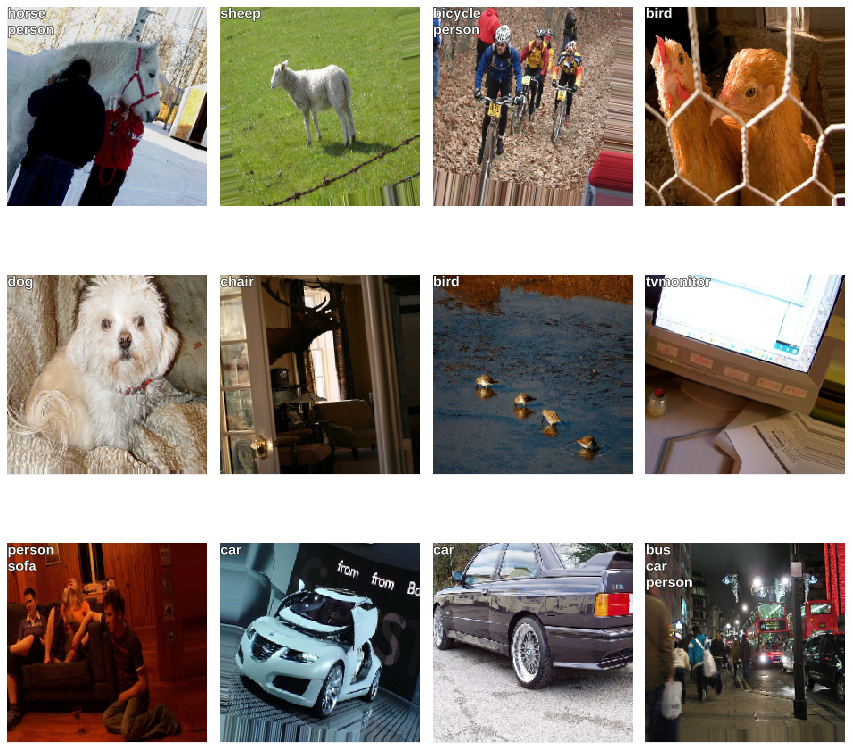

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for i,ax in enumerate(axes.flat):
    x,y = train_batches.next()
    image = x[0]

    ind = np.where(y[0,:]==1)
    b = '\n'.join(data_category[o+1] for o in ind[0])
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_text(ax, (0,0), b)

plt.tight_layout()

### 2: The model

In [ ]:
sz=224
bs=64

net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False
 
y = net.output
y = Flatten()(y)
y = Dropout(0.5)(y)

output_layer_class = Dense(NbClasses, activation='sigmoid', name='layer_class')(y)

model = Model(inputs=net.input, outputs=output_layer_class) 
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
bloc

### 3: The optimizer

We have to pay attention to our Loss function here. Indeed, we predict multi categories per image. Y is no more a vector of zeros and a one somewhere, but instead, we have multiple one, as much as the number of label in the image.

As a consequence, we can not use anymore <kbd>SoftMax</kbd> as an activation, but a <kbd>sigmoid</kbd> instead. Further more, as we have changed our activation layer, we have also to update our <kbd>Loss</kbd> function. <kbd>Categorical_crossentropy</kbd> does not work anymore as we have multi-labels. As each activation is supposed to be fully independant, we select <kbd>binary_crossentropy</kbd>: in a defined image, there is no relationship between label cat and label chair!

In [ ]:
optimizer=Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['accuracy'])

### 4: training phase

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
54/54 [==============================] - 42s 778ms/step - loss: 1.4092 - acc: 0.8786 - val_loss: 0.9242 - val_acc: 0.9340
Epoch 2/10
54/54 [==============================] - 39s 728ms/step - loss: 0.9454 - acc: 0.9306 - val_loss: 0.8505 - val_acc: 0.9399
Epoch 3/10
54/54 [==============================] - 38s 705ms/step - loss: 0.8787 - acc: 0.9348 - val_loss: 0.8010 - val_acc: 0.9435
Epoch 4/10
54/54 [==============================] - 44s 806ms/step - loss: 0.8439 - acc: 0.9367 - val_loss: 0.7625 - val_acc: 0.9466
Epoch 5/10
54/54 [==============================] - 38s 696ms/step - loss: 0.7796 - acc: 0.9408 - val_loss: 0.7397 - val_acc: 0.9468
Epoch 6/10
54/54 [==============================] - 38s 695ms/step - loss: 0.7371 - acc: 0.9421 - val_loss: 0.6955 - val_acc: 0.9490
Epoch 7/10
54/54 [==============================] - 37s 686ms/step - loss: 0.7005 - acc: 0.9445 - val_loss: 0.6722 - val_acc: 0.9505
Epoch 8/10
54/54 [===

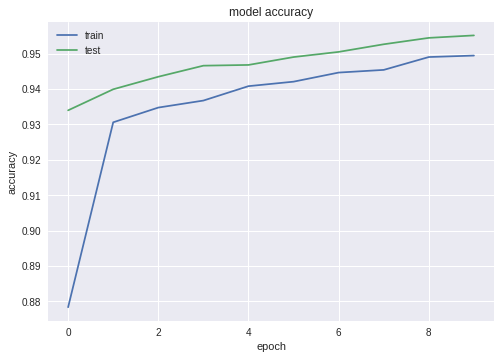

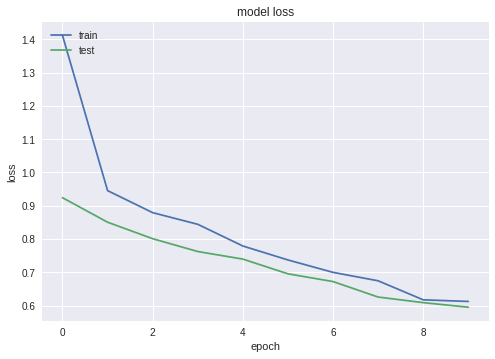

In [ ]:
epochs = 10

history = model.fit_generator(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              validation_data=valid_batches,
                              validation_steps = valid_batches.n // valid_batches.batch_size)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 5: unfreeze few layers

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/10
54/54 [==============================] - 39s 731ms/step - loss: 0.5805 - acc: 0.9527 - val_loss: 0.5859 - val_acc: 0.9566
Epoch 2/10
54/54 [==============================] - 38s 710ms/step - loss: 0.5740 - acc: 0.9521 - val_loss: 0.5589 - val_acc: 0.9568
Epoch 3/10
54/54 [==============================] - 38s 701ms/step - loss: 0.5267 - acc: 0.9551 - val_loss: 0.5481 - val_acc: 0.9579
Epoch 4/10
54/54 [==============================] - 38s 701ms/step - loss: 0.5023 - acc: 0.9559 - val_loss: 0.5365 - val_acc: 0.9585
Epoch 5/10
54/54 [==============================] - 37s 690ms/step - loss: 0.4961 - acc: 0.9580 - val_loss: 0.5246 - val_acc: 0.9586
Epoch 6/10
54/54 [==============================] - 37s 689ms/step - loss: 0.4693 - acc: 0.9600 - val_loss: 0.5247 - val_acc: 0.9589
Epoch 7/10
54/54 [==============================] - 37s 684ms/step - loss: 0.4673 - acc: 0.9598 - val_loss: 0.5217 - val_acc: 0.9579
Epoch 8/10
54/54 [==============================] - 37s 677ms/step - 

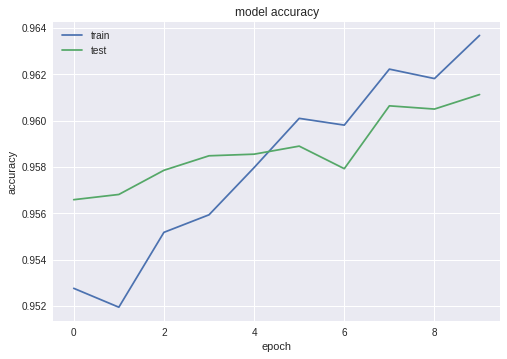

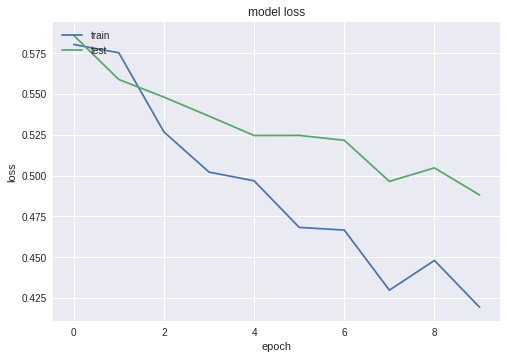

In [ ]:
FREEZE_LAYERS = 14

# free the first layers
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True
print(model.summary())    
epochs = 10

history = model.fit_generator(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              validation_data=valid_batches,
                              validation_steps = valid_batches.n // valid_batches.batch_size)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 6: check the result

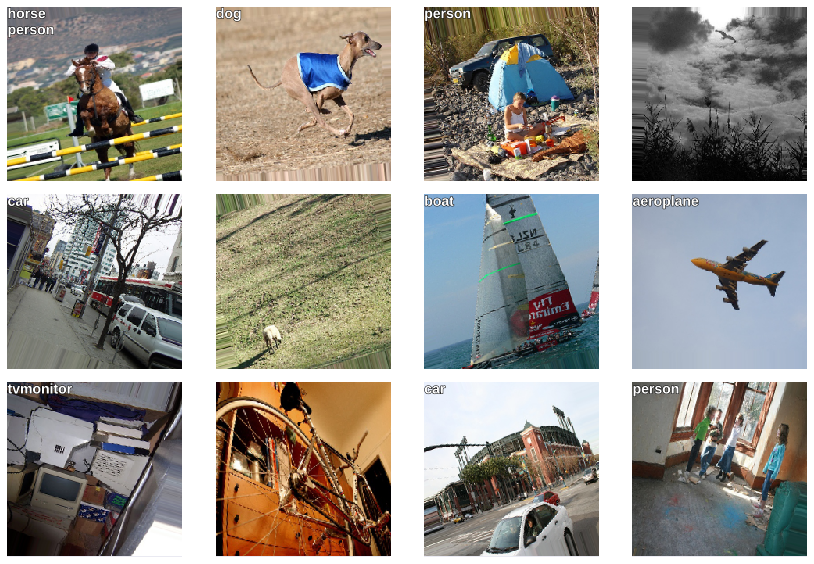

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    x,y = train_batches.next()
    image = x[0]
    yPred = model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)    
    ind = np.where(yPred[0]>0.4)
    b = '\n'.join(data_category[o+1] for o in ind[0])
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_text(ax, (0,0), b)

plt.tight_layout()